In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2023-04-06 03:15:24--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2023-04-06 03:15:24 (12.8 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



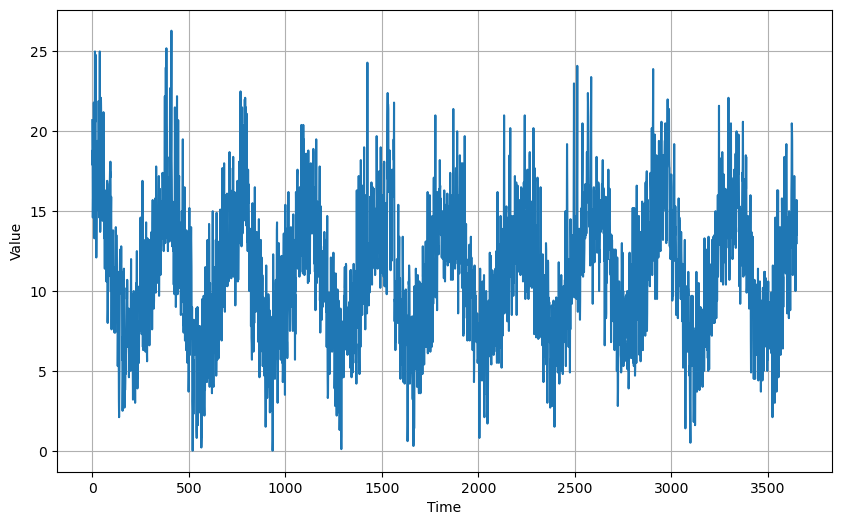

In [3]:
import csv
time_step = []
temps = []

with open('/kaggle/working/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

(3650,)

In [4]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=20)# YOUR CODE HERE)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/20
25/25 [==============================] - 8s 122ms/step - loss: 5.8076 - mae: 6.2877
Epoch 2/20
25/25 [==============================] - 3s 110ms/step - loss: 2.2283 - mae: 2.6856
Epoch 3/20
25/25 [==============================] - 3s 108ms/step - loss: 1.9550 - mae: 2.4077
Epoch 4/20
25/25 [==============================] - 3s 106ms/step - loss: 1.9181 - mae: 2.3703
Epoch 5/20
25/25 [==============================] - 3s 107ms/step - loss: 1.8964 - mae: 2.3483
Epoch 6/20
25/25 [==============================] - 3s 106ms/step - loss: 1.8674 - mae: 2.3192
Epoch 7/20
25/25 [==============================] - 3s 108ms/step - loss: 1.8395 - mae: 2.2905
Epoch 8/20
25/25 [==============================] - 3s 107ms/step - loss: 1.8275 - mae: 2.2787
Epoch 9/20
25/25 [==============================] - 3s 108ms/step - loss: 1.8136 - mae: 2.2646
Epoch 10/20
25/25 [==============================] - 3s 109ms/step - loss: 1.8032 - mae: 2.2540
Epoch 11/20
25/25 [==============================

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


114/114 [==============================] - 2s 13ms/step
(3621, 30, 1)


In [11]:
print(rnn_forecast.shape)

(1150,)


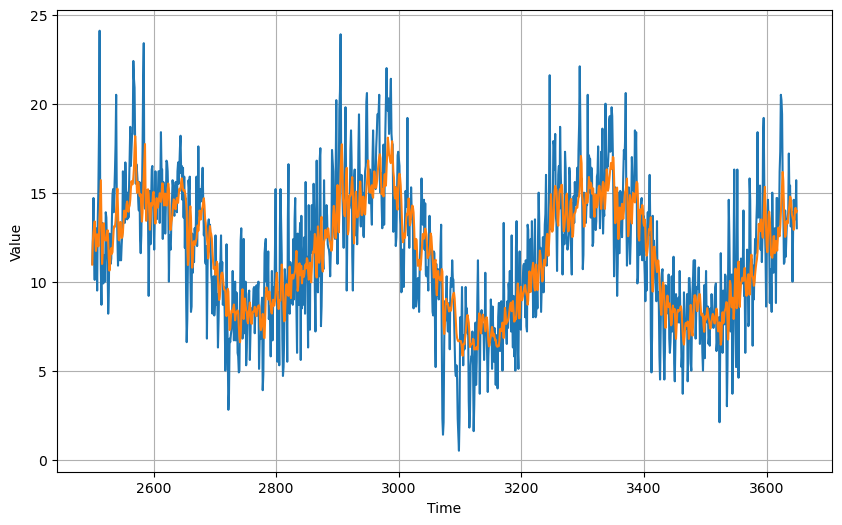

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.9659791